# Pokemon Type Prediction
Given the base stats, names, and images of a Pokemon, train a model using supervised learning that is able to classify a Pokemon's type.

In [1]:
!pip install -r requirements.txt

In [2]:
# Model helpers and scorers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Actual models -- add to these
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras_preprocessing.image import img_to_array

## Data Preprocessing
For data preprocessing, we:
1. Remove rows with invalid primary types
2. Drop unneeded columns
3. Extract the features and labels
4. Make train-test splits

In [3]:
pokedex = pd.read_csv('data/Pokedex_Cleaned.csv', encoding='latin-1')
pokedex

,#,Name,Primary Type,Secondary Type,Total,HP,Attack,Defense,Sp.Atk,Sp.Def,Speed,Variant
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,NaN
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,NaN
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,NaN
3,3,Venusaur,Grass,Poison,625,80,100,123,122,120,80,NaN
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1168,1004,Chi-Yu,Dark,Fire,570,55,80,80,135,120,100,NaN
1169,1005,Roaring Moon,Dragon,Dark,590,105,139,71,55,101,119,NaN
1170,1006,Iron Valiant,Fairy,Fighting,590,74,130,90,120,60,116,NaN
1171,1007,Koraidon,Fighting,Dragon,670,100,135,115,85,100,135,NaN


In [4]:
primary_types = pokedex['Primary Type']
primary_types.value_counts()  # need to remove rows that aren't types

Water       147
Normal      130
Grass       102
Bug          99
Psychic      76
Fire         73
Electric     73
Rock         67
Dark         56
Dragon       47
Ground       47
Ghost        46
Poison       46
Fighting     46
Steel        42
Fairy        32
Ice          27
Flying       12
Null          2
Male          1
Female        1
Rockruff      1
Name: Primary Type, dtype: int64

In [5]:
not_types = {"Null", "Male", "Female", "Rockruff"}
pokedex = pokedex.loc[~pokedex['Primary Type'].isin(not_types)]  # remove rows with invalid types
primary_types = pokedex['Primary Type']
primary_types.value_counts()  # bad rows are gone

Water       147
Normal      130
Grass       102
Bug          99
Psychic      76
Fire         73
Electric     73
Rock         67
Dark         56
Dragon       47
Ground       47
Poison       46
Ghost        46
Fighting     46
Steel        42
Fairy        32
Ice          27
Flying       12
Name: Primary Type, dtype: int64

In [6]:
# Drop irrelevant rows, columns, reorder name
pokemon_names = pokedex['Name'].copy()
pokedex_relevant = pokedex.drop(['#', 'Name', 'Secondary Type', 'Total', 'Variant'], axis=1)
pokedex_relevant['Name'] = pokemon_names
pokedex_relevant

,Primary Type,HP,Attack,Defense,Sp.Atk,Sp.Def,Speed,Name
0,Grass,45,49,49,65,65,45,Bulbasaur
1,Grass,60,62,63,80,80,60,Ivysaur
2,Grass,80,82,83,100,100,80,Venusaur
3,Grass,80,100,123,122,120,80,Venusaur
4,Fire,39,52,43,60,50,65,Charmander
...,...,...,...,...,...,...,...,...
1168,Dark,55,80,80,135,120,100,Chi-Yu
1169,Dragon,105,139,71,55,101,119,Roaring Moon
1170,Fairy,74,130,90,120,60,116,Iron Valiant
1171,Fighting,100,135,115,85,100,135,Koraidon


In [7]:
pokedex_relevant.Name.tolist()

['Bulbasaur',
 'Ivysaur',
 'Venusaur',
 'Venusaur',
 'Charmander',
 'Charmeleon',
 'Charizard',
 'Charizard',
 'Charizard',
 'Squirtle',
 'Wartortle',
 'Blastoise',
 'Blastoise',
 'Caterpie',
 'Metapod',
 'Butterfree',
 'Weedle',
 'Kakuna',
 'Beedrill',
 'Beedrill',
 'Pidgey',
 'Pidgeotto',
 'Pidgeot',
 'Pidgeot',
 'Rattata',
 'Rattata',
 'Raticate',
 'Raticate',
 'Spearow',
 'Fearow',
 'Ekans',
 'Arbok',
 'Pikachu',
 'Pikachu',
 'Raichu',
 'Raichu',
 'Sandshrew',
 'Sandshrew',
 'Sandslash',
 'Sandslash',
 'Nidoran?',
 'Nidorina',
 'Nidoqueen',
 'Nidoran?',
 'Nidorino',
 'Nidoking',
 'Clefairy',
 'Clefable',
 'Vulpix',
 'Vulpix',
 'Ninetales',
 'Ninetales',
 'Jigglypuff',
 'Wigglytuff',
 'Zubat',
 'Golbat',
 'Oddish',
 'Gloom',
 'Vileplume',
 'Paras',
 'Parasect',
 'Venonat',
 'Venomoth',
 'Diglett',
 'Dugtrio',
 'Meowth',
 'Persian',
 'Persian',
 'Psyduck',
 'Golduck',
 'Mankey',
 'Primeape',
 'Growlithe',
 'Growlithe',
 'Arcanine',
 'Arcanine',
 'Poliwag',
 'Poliwhirl',
 'Poliwrath',

In [8]:
# extract features and labels
features = pokedex_relevant.iloc[:, 1:-1].values.astype(float)
# normalize numbers
for feature in features:
    s = sum(feature)
    feature /= s
labels = pokedex_relevant.iloc[:, 0].values
features, labels

(array([[0.14150943, 0.15408805, 0.15408805, 0.20440252, 0.20440252,
         0.14150943],
        [0.14814815, 0.15308642, 0.15555556, 0.19753086, 0.19753086,
         0.14814815],
        [0.15238095, 0.15619048, 0.15809524, 0.19047619, 0.19047619,
         0.15238095],
        ...,
        [0.12542373, 0.22033898, 0.15254237, 0.20338983, 0.10169492,
         0.19661017],
        [0.14925373, 0.20149254, 0.17164179, 0.12686567, 0.14925373,
         0.20149254],
        [0.14925373, 0.12686567, 0.14925373, 0.20149254, 0.17164179,
         0.20149254]]),
 array(['Grass', 'Grass', 'Grass', ..., 'Fairy', 'Fighting', 'Electric'],
       dtype=object))

In [9]:
# train test splits -- stats
# Stratify on labels to ensure each class has equal proportions
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, stratify=labels)  # random_state=42

In [10]:
# train test splits -- names
# Stratify on labels to ensure each class has equal proportions
features = pokedex_relevant.iloc[:, -1].values
X_train_name, X_test_name, y_train_name, y_test_name = train_test_split(features, labels, test_size = 0.2, stratify=labels)  # random_state=42

## Decision Tree Approach using Entropy

In [11]:
# Decision tree with entropy
clf_entropy = DecisionTreeClassifier(
        criterion = "entropy")
# Performing training
entropy_model = clf_entropy.fit(X_train, y_train)

# Prediction using entropy, display results

print("For test set:")
y_pred = entropy_model.predict(X_test)
print("Confusion Matrix: ",
confusion_matrix(y_test, y_pred))

print ("Accuracy : ",
accuracy_score(y_test,y_pred)*100)

print("Report : ",
classification_report(y_test, y_pred))

print("For train set:")
y_pred = entropy_model.predict(X_train)
print("Confusion Matrix: ",
confusion_matrix(y_train, y_pred))

print ("Accuracy : ",
accuracy_score(y_train,y_pred)*100)  # high train accuracy but low test accuracy... potentially overfitting?

print("Report : ",
classification_report(y_train, y_pred))

For test set:
Confusion Matrix:  [[9 0 0 1 0 0 0 0 1 1 2 1 2 0 1 0 0 2]
 [2 2 0 0 1 0 0 0 1 0 0 0 2 2 0 0 0 1]
 [0 0 2 1 0 1 0 0 0 0 0 0 0 1 1 1 0 2]
 [1 0 0 8 0 0 1 1 0 0 0 0 0 0 0 1 2 1]
 [0 0 0 0 0 1 0 0 0 2 0 0 0 1 1 1 0 0]
 [0 0 0 0 1 2 1 1 0 0 1 0 0 0 1 0 1 1]
 [0 0 1 1 1 0 1 0 0 2 1 0 3 0 3 1 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [2 1 1 1 0 0 0 0 1 2 0 0 0 0 1 0 0 0]
 [1 0 1 0 1 1 2 0 1 4 1 0 2 2 0 1 0 4]
 [0 1 3 1 0 0 0 0 2 0 0 0 1 0 0 0 0 2]
 [0 1 0 0 1 0 2 0 0 0 0 0 0 0 0 1 0 0]
 [2 1 4 0 1 2 2 2 0 0 1 0 8 1 0 0 0 2]
 [0 0 0 0 0 0 0 0 1 1 0 1 2 1 0 1 0 2]
 [3 0 0 2 0 0 1 0 1 1 0 0 3 0 1 0 1 2]
 [3 1 2 0 0 0 0 0 0 1 0 0 1 0 0 3 0 3]
 [2 0 0 0 0 0 1 0 2 0 0 0 0 0 0 3 0 0]
 [2 0 2 5 1 0 1 0 3 4 1 0 3 0 3 0 0 5]]
Accuracy :  20.085470085470085
Report :                precision    recall  f1-score   support

         Bug       0.33      0.45      0.38        20
        Dark       0.29      0.18      0.22        11
      Dragon       0.12      0.22      0.15         9
    El

# SVM

In [12]:
svc_class = SVC(kernel='rbf')

# SVM training
svm_model = svc_class.fit(X_train,y_train)

# Prediction 
print("For test set:")
y_pred = svm_model.predict(X_test)
print("Confusion Matrix: ",
confusion_matrix(y_test, y_pred))

print ("Accuracy : ",
accuracy_score(y_test,y_pred)*100)

print("Report : ",
classification_report(y_test, y_pred))

print("For train set:")
y_pred = svm_model.predict(X_train)
print("Confusion Matrix: ",
confusion_matrix(y_train, y_pred))

print ("Accuracy : ",
accuracy_score(y_train,y_pred)*100)

print("Report : ",
classification_report(y_train, y_pred))

For test set:
Confusion Matrix:  [[ 8  0  0  1  0  2  0  0  0  2  1  0  3  0  0  1  1  1]
 [ 1  0  1  0  0  2  0  0  0  0  1  0  2  0  0  0  0  4]
 [ 0  0  0  0  0  2  1  0  0  1  0  0  1  0  0  0  0  4]
 [ 1  0  0  7  0  0  3  0  0  0  0  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  2  0  0  3]
 [ 0  0  0  0  0  2  1  0  0  0  0  0  4  0  0  0  0  2]
 [ 0  0  0  2  0  0  5  0  0  2  0  0  2  0  1  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1]
 [ 4  0  0  0  0  0  1  0  0  1  0  0  1  0  2  0  0  0]
 [ 2  0  0  1  0  0  3  0  0  2  0  0  2  0  1  0  1  9]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  5]
 [ 0  0  0  1  0  1  0  0  0  1  0  0  1  0  0  0  0  1]
 [ 0  0  0  2  0  2  2  0  0  0  0  0 15  0  0  0  0  5]
 [ 1  0  0  0  0  0  1  0  0  1  0  0  2  0  0  1  0  3]
 [ 0  0  0  0  0  1  3  0  0  2  0  0  0  0  5  0  0  4]
 [ 1  0  0  0  0  1  0  0  1  0  1  0  2  0  1  2  0  5]
 [ 4  0  0  0  0  1  0  0  0  0  1  0  0  0  0  1  1  0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

# GAN

In [13]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = 'data/images'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    img = cv2.imread(path + '/'+i,1)
    # open cv reads images in BGR format so we have to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = (img - 127.5) / 127.5
    img = img.astype(float)
    _img.append(img_to_array(img))

100%|█████████████████████████████████████████████████████████████████████████████| 1010/1010 [00:01<00:00, 663.96it/s]


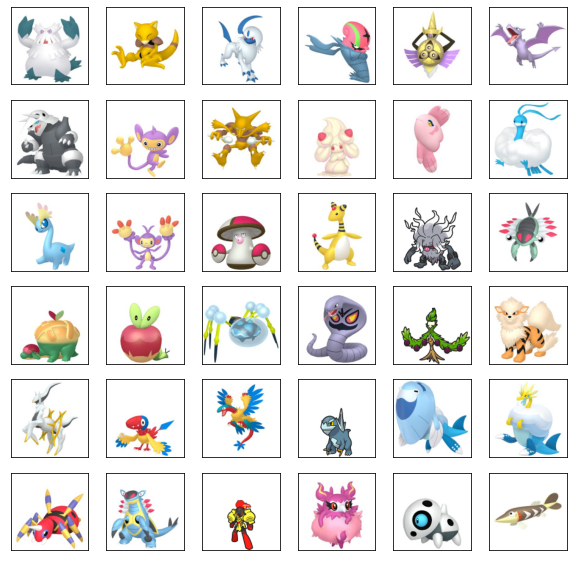

In [14]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(6)

In [15]:
batch_size = 32  # try different numbers here
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

In [16]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

    return model

In [17]:
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     6144      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                        

In [18]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model
  

In [19]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)      

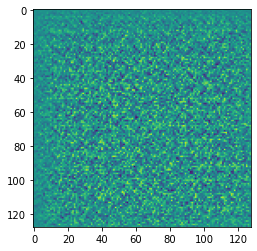

In [20]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [21]:
optimizer = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

In [23]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [24]:
def plot_generated_images(square = 5, epochs = 0):
    
    
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

In [25]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

In [ ]:
train(5,dataset)
# i had train model previously for more than 10 epochs so generated images are quite good


Epoch : 1


In [ ]:
plot_generated_images(1)

### Training:
Do SVM, add images in addition to classic features using MLP (first notebook assignment), CNN (followup notebook assignment), 
get vector, normalize, do softmax to pick one class,
look into resnet, and GAN for data augmentation (the Kaggle link--generates new images)

Consider other ways of data augmentation like rotation, shifts, background changes?

### Evaluation:
Precision, recall, F1 PER LABEL, confusion matrix

Use validation set (10% from training) for neural networks to fine-tune parameters.

Add them back to training set when the parameters are producing better results (so it's 80% for training again).

### Error Analysis:
See which classes are harder to identify (e.g. psychic, normal, ...)

See learning curves to check if increasing training data helps or not.

### Resources: 
https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-resnet#:~:text=Own%20ResNet%20Architecture-,ResNet%20Architecture,layers%2C%20which%20outperform%20shallower%20networks.
https://pytorch.org/vision/main/models/generated/torchvision.models.resnet152.html#:~:text=ResNet%2D152%20from%20Deep%20Residual,5.
https://www.kaggle.com/code/scratchpad/notebook3b2c42d3e9/edit

Identify Pokemon  team 5: 
1. SVM 
2. Images => CNN => MLP classification 
3. ResNet => MLP classification 
4. Data augmentation with GAN or other image transformations => them use the 2 and 3 models to classify
5. Evaluation : Label (Precision, recall, F1 per label and confusion matrix. )
6. Tuning parameters using 100 examples from training data and using is as development set. 
7. Error analysis 
8. Learning curve => number of data and number of epochs used.